#### **Summary : Market Basket Analysis (Association Rules Mining)**

**Goal:**
Discover relationships between products in transactional datasets to understand “people who bought X also bought Y” patterns, which can be used for recommendation engines, cross-selling, and marketing strategies.

**Dataset:**
- Groceries dataset (or any transactional dataset with `Member_number`, `Date`, `itemDescription` columns)

**Techniques:**

- Apriori Algorithm → Find frequent itemsets.
- Association Rules → Generate rules with support, confidence, lift.

**Key Visualizations:**

- Support vs Confidence Scatterplot → Helps visualize rule strength and frequency.
- Network Graph → Shows relationships between items, with lift as edge strength.

**Insights & Real-World Impact:**

- Cross-sell & upsell opportunities.
- Personalized recommendations in e-commerce.
- Inventory & promotion optimization.
- Easy-to-interpret visualizations help management decisions.

### Step 1: Import libraries

In [27]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import networkx as nx

### Step 2: Load the dataset

In [28]:
# dataset: https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset
df = pd.read_csv('Data/Groceries_dataset.csv', header=0)
print("Shape:", df.shape)
df.head()


Shape: (38765, 3)


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


### Step 3: Data Preprocessing -> One-hot encoding

In [29]:
# Group transactions by Member_number and aggregate items
transactions = df.groupby('Member_number')['itemDescription'].apply(list).values.tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket = pd.DataFrame(te_ary, columns=te.columns_)

### Step 4: Apply Apriori to find frequent itemsets

In [30]:
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
print("Frequent itemsets (top 10):")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))

Frequent itemsets (top 10):
       support                        itemsets  length
113   0.458184                    (whole milk)       1
69    0.376603              (other vegetables)       1
84    0.349666                    (rolls/buns)       1
94    0.313494                          (soda)       1
114   0.282966                        (yogurt)       1
106   0.233710                (tropical fruit)       1
85    0.230631               (root vegetables)       1
7     0.213699                 (bottled water)       1
89    0.206003                       (sausage)       1
1050  0.191380  (whole milk, other vegetables)       2


### Step 5: Generate association rules

In [31]:
# Generate rules from all frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# Filter only rules with 2+ items in antecedent or consequent if needed
rules = rules[(rules['antecedents'].apply(lambda x: len(x) >= 1)) & 
              (rules['consequents'].apply(lambda x: len(x) >= 1))]

# Sort by lift
rules = rules.sort_values(by='lift', ascending=False)
print("\nTop 10 association rules:")
print(rules.head(10))



Top 10 association rules:
                                        antecedents  \
3379        (other vegetables, rolls/buns, sausage)   
2896                     (frozen meals, whole milk)   
3372            (yogurt, rolls/buns, bottled water)   
3388            (yogurt, shopping bags, rolls/buns)   
2838                                (curd, sausage)   
3382                  (yogurt, whole milk, sausage)   
3390            (yogurt, whole milk, shopping bags)   
3381            (yogurt, other vegetables, sausage)   
3387  (shopping bags, rolls/buns, other vegetables)   
2898               (frozen meals, other vegetables)   

                         consequents  antecedent support  consequent support  \
3379            (yogurt, whole milk)            0.041816            0.150590   
2896  (rolls/buns, other vegetables)            0.032581            0.146742   
3372  (whole milk, other vegetables)            0.026424            0.191380   
3388  (whole milk, other vegetables)           

### Step 6: Visualization of top rules

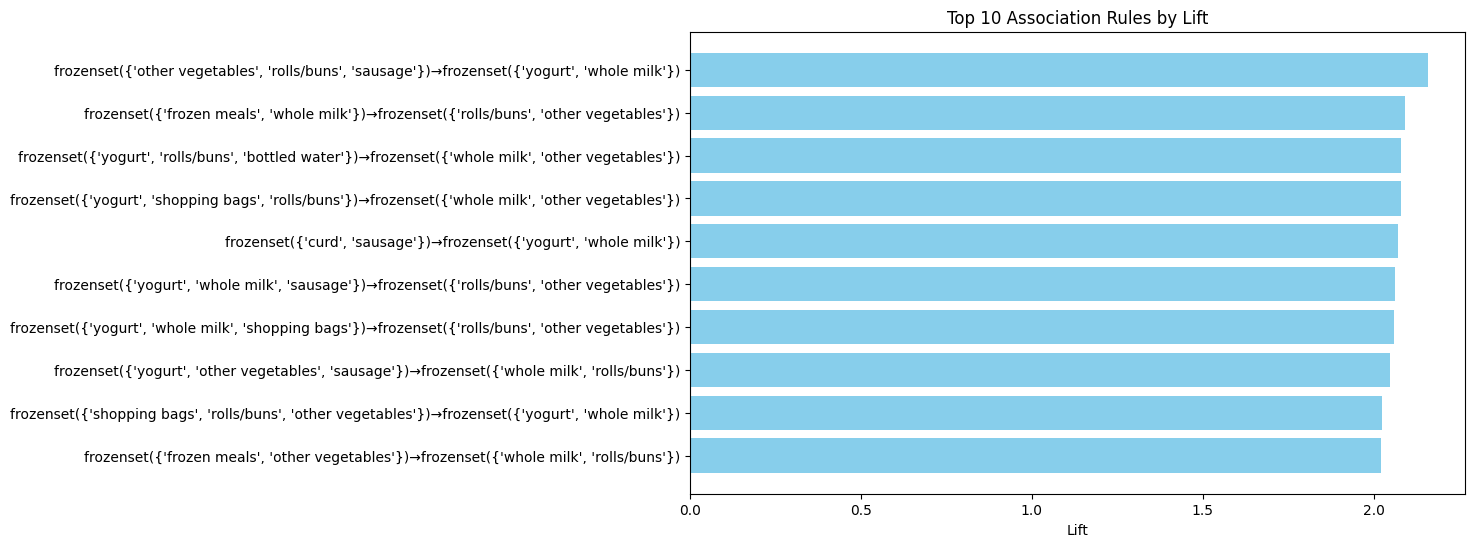

In [35]:
top_rules = rules.head(10)

# Plot bar chart for lift
plt.figure(figsize=(10,6))
plt.barh(range(len(top_rules)), top_rules['lift'], color='skyblue')
plt.yticks(range(len(top_rules)), [str(a)+"→"+str(b) for a,b in zip(top_rules['antecedents'], top_rules['consequents'])])
plt.xlabel('Lift')
plt.title('Top 10 Association Rules by Lift')
plt.gca().invert_yaxis()
plt.show()

### Network graph visualization

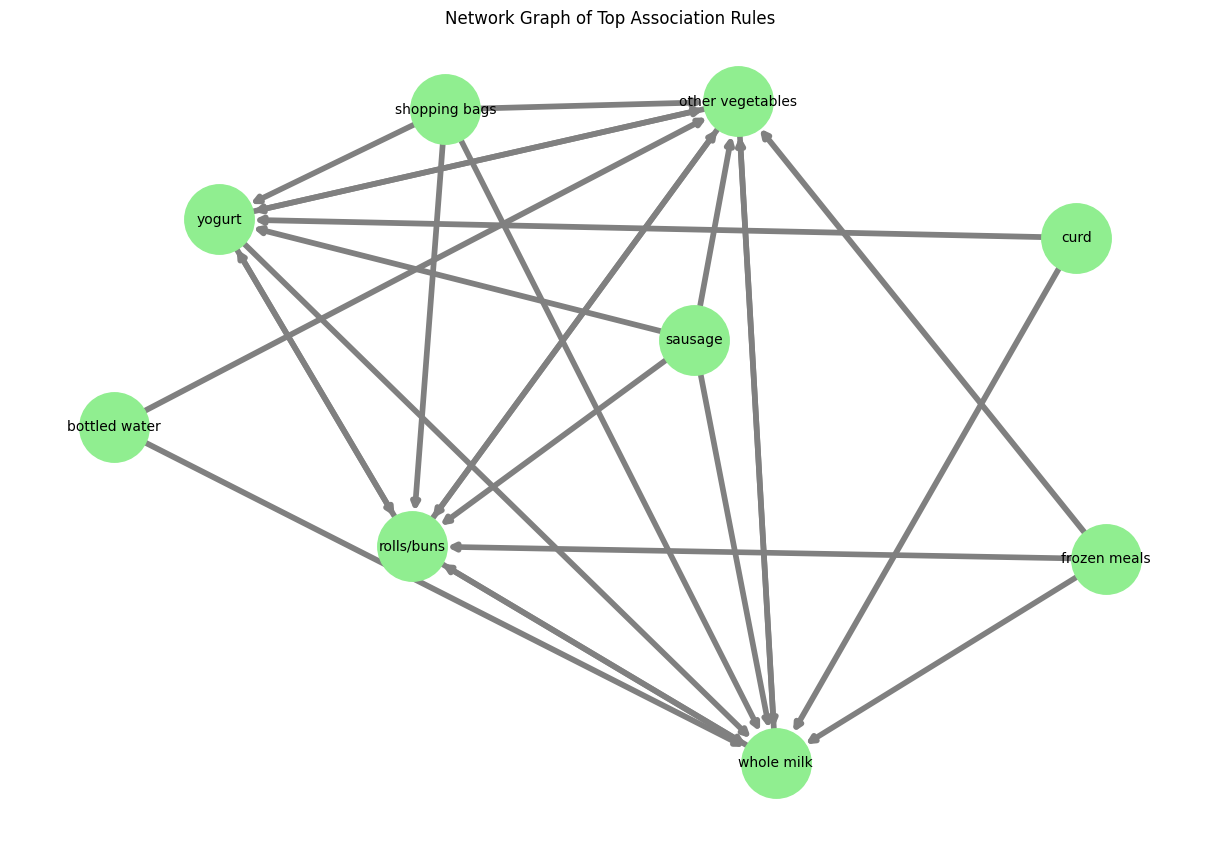

In [36]:
G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=1)
edges = G.edges()
weights = [G[u][v]['weight']*2 for u,v in edges]
nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='gray', width=weights, node_size=2500, font_size=10)
plt.title("Network Graph of Top Association Rules")
plt.show()